In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/STAT/AMZN_Clean.csv')  # Replace with the actual file path

# Convert 'Date' to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select relevant columns (we are predicting 'Close')
data = data[['Adj Close']]

# Normalize the 'Close' column
scaler = MinMaxScaler()
data['Adj Close'] = scaler.fit_transform(data[['Adj Close']])

# Create sequences of past data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values  # Past `seq_length` values
        label = data.iloc[i + seq_length].values  # Next value
        sequences.append((seq, label))
    return sequences

seq_length = 60  # Use 20 past days to predict the next
sequences = create_sequences(data, seq_length)

# Split into features (X) and labels (y)
X, y = zip(*sequences)
X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes
print(f"Train Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, {y_test.shape}")


Train Data Shape: (958, 60, 1), (958, 1)
Test Data Shape: (240, 60, 1), (240, 1)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Transformer model
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, seq_length):
        super(TransformerTimeSeries, self).__init__()
        self.model_dim = model_dim
        self.seq_length = seq_length

        # Input and output layers
        self.input_layer = nn.Linear(input_dim, model_dim)
        self.output_layer = nn.Linear(model_dim, output_dim)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, model_dim))

        # Transformer
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            batch_first=True
        )

    def forward(self, src):
        # Add positional encoding
        src = self.input_layer(src) + self.positional_encoding

        # Use src as both the encoder and decoder inputs
        output = self.transformer(src, src)

        # Predict the next value based on the last sequence
        return self.output_layer(output[:, -1, :])

# Model parameters
input_dim = 1  # One feature: 'Close'
model_dim = 64
num_heads = 4
num_layers = 2
output_dim = 1

# Instantiate the model
model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, output_dim, seq_length)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
epochs = 40
batch_size = 32

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        labels = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(X_train_tensor):.4f}")


Epoch 1/40, Loss: 0.0121
Epoch 2/40, Loss: 0.0016
Epoch 3/40, Loss: 0.0040
Epoch 4/40, Loss: 0.0072
Epoch 5/40, Loss: 0.0087
Epoch 6/40, Loss: 0.0073
Epoch 7/40, Loss: 0.0054
Epoch 8/40, Loss: 0.0048
Epoch 9/40, Loss: 0.0047
Epoch 10/40, Loss: 0.0046
Epoch 11/40, Loss: 0.0044
Epoch 12/40, Loss: 0.0043
Epoch 13/40, Loss: 0.0040
Epoch 14/40, Loss: 0.0018
Epoch 15/40, Loss: 0.0039
Epoch 16/40, Loss: 0.0048
Epoch 17/40, Loss: 0.0029
Epoch 18/40, Loss: 0.0029
Epoch 19/40, Loss: 0.0058
Epoch 20/40, Loss: 0.0035
Epoch 21/40, Loss: 0.0013
Epoch 22/40, Loss: 0.0021
Epoch 23/40, Loss: 0.0008
Epoch 24/40, Loss: 0.0005
Epoch 25/40, Loss: 0.0006
Epoch 26/40, Loss: 0.0005
Epoch 27/40, Loss: 0.0005
Epoch 28/40, Loss: 0.0005
Epoch 29/40, Loss: 0.0005
Epoch 30/40, Loss: 0.0004
Epoch 31/40, Loss: 0.0004
Epoch 32/40, Loss: 0.0004
Epoch 33/40, Loss: 0.0003
Epoch 34/40, Loss: 0.0004
Epoch 35/40, Loss: 0.0003
Epoch 36/40, Loss: 0.0003
Epoch 37/40, Loss: 0.0003
Epoch 38/40, Loss: 0.0002
Epoch 39/40, Loss: 0.

                                 True   Predicted
Date                                             
2023-01-18 00:00:00+00:00   95.459999   96.801086
2023-01-19 00:00:00+00:00   93.680000   96.295006
2023-01-20 00:00:00+00:00   97.250000   96.022667
2023-01-23 00:00:00+00:00   97.519997   95.706566
2023-01-24 00:00:00+00:00   96.320000   97.162292
...                               ...         ...
2023-12-22 00:00:00+00:00  153.419998  165.352478
2023-12-26 00:00:00+00:00  153.410004  165.328033
2023-12-27 00:00:00+00:00  153.339996  165.316666
2023-12-28 00:00:00+00:00  153.380005  165.498535
2023-12-29 00:00:00+00:00  151.940002  165.504486

[240 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


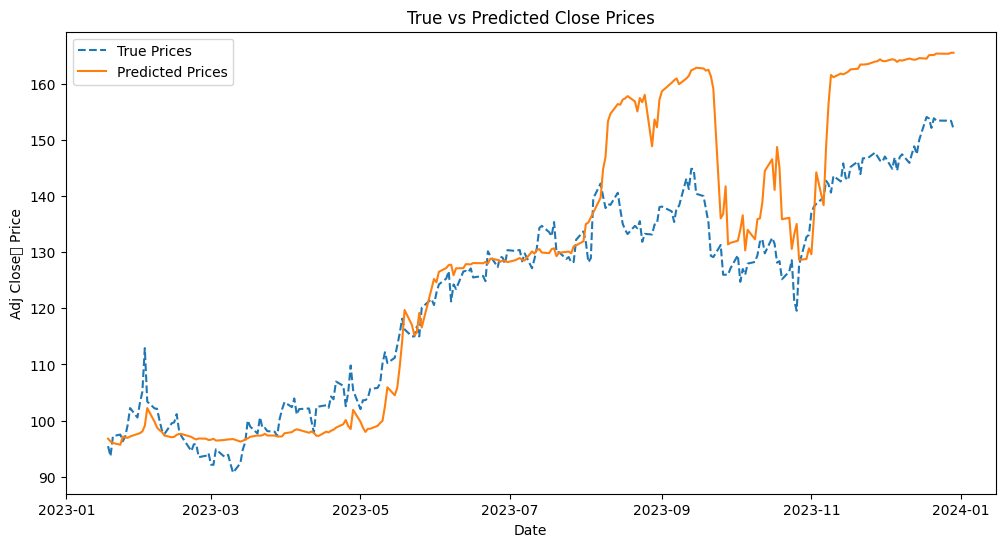

In [12]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# Rescale the predictions and true values back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

# Create a DataFrame for visualization
test_dates = data.index[-len(y_test):]  # Get test dates
results = pd.DataFrame({
    'Date': test_dates,
    'True': y_test_original.flatten(),
    'Predicted': predictions.flatten()
}).set_index('Date')

print(results)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results.index, results['True'], label='True Prices', linestyle='--')
plt.plot(results.index, results['Predicted'], label='Predicted Prices')
plt.title('True vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Adj Close	 Price')
plt.legend()
plt.show()


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv("your_dataframe.csv")  # Load your DataFrame if it's in a file
# Assuming the DataFrame has the structure as shown in the screenshot:
# Columns: 'Date', 'True', 'Predicted'

# RMSE
rmse = np.sqrt(mean_squared_error(results['True'], results['Predicted']))

# MAE
mae = mean_absolute_error(results['True'], results['Predicted'])

# MAPE
mape = np.mean(np.abs((results['True'] - results['Predicted']) / results['True'])) * 100

# R-squared
r2 = r2_score(results['True'], results['Predicted'])

# Directional Accuracy
direction_true = np.sign(results['True'].diff().dropna())  # True price changes
direction_pred = np.sign(results['Predicted'].diff().dropna())  # Predicted price changes
directional_accuracy = np.mean(direction_true == direction_pred)

# Print metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.2f}")
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")


RMSE: 11.08
MAE: 8.11
MAPE: 6.21%
R-squared: 0.63
Directional Accuracy: 47.70%


                            Adj Close
Date                                 
2019-01-02 00:00:00+00:00   76.956497
2019-01-03 00:00:00+00:00   75.014000
2019-01-04 00:00:00+00:00   78.769501
2019-01-07 00:00:00+00:00   81.475502
2019-01-08 00:00:00+00:00   82.829002
...                               ...
2023-12-22 00:00:00+00:00  153.419998
2023-12-26 00:00:00+00:00  153.410004
2023-12-27 00:00:00+00:00  153.339996
2023-12-28 00:00:00+00:00  153.380005
2023-12-29 00:00:00+00:00  151.940002

[1258 rows x 1 columns]


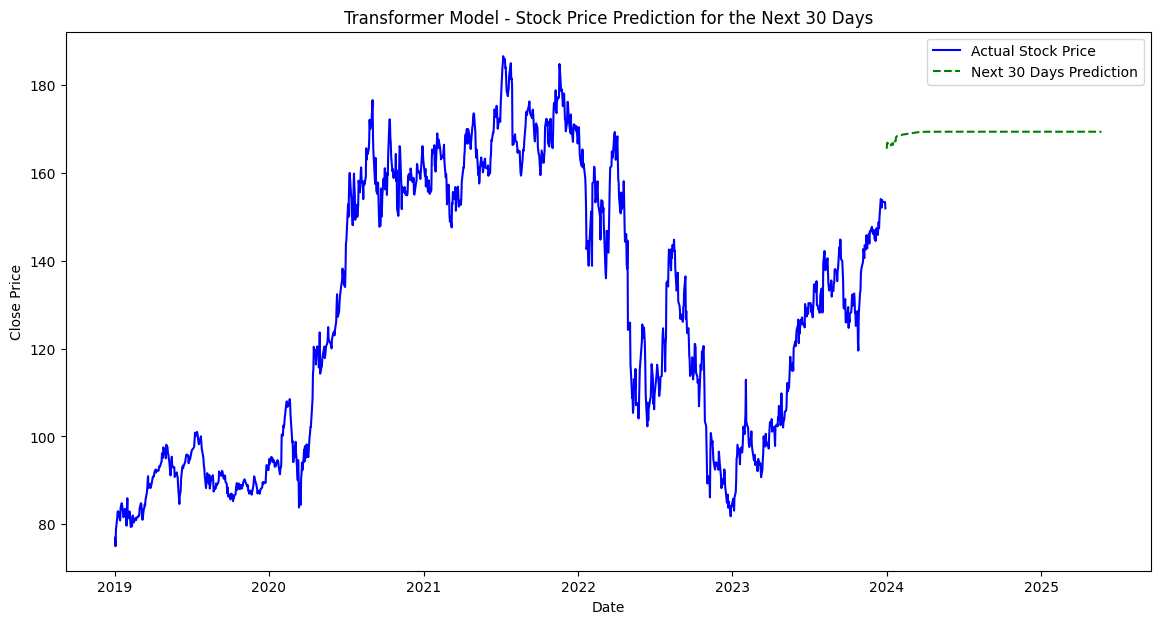

In [14]:
# Predict the next 30 days
model.eval()
last_sequence = X_test_tensor[-1].unsqueeze(0)  # Start with the last sequence in the dataset
future_predictions = []
for _ in range(365):
    with torch.no_grad():
        next_pred = model(last_sequence)
        future_predictions.append(next_pred.item())
        # Update the input sequence
        next_input = torch.cat((last_sequence[:, 1:, :], next_pred.unsqueeze(2)), dim=1)
        last_sequence = next_input

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame for the next 30 days
data = pd.read_csv('/content/drive/MyDrive/STAT/AMZN_Clean.csv')  # Replace with the actual file path
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select relevant columns (we are predicting 'Close')
data = data[['Adj Close']]
print(data)
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='B')
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted'])

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'], label='Actual Stock Price', color='blue')
plt.plot(future_df['Predicted'], label='Next 30 Days Prediction', color='green', linestyle='--')
plt.title('Transformer Model - Stock Price Prediction for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
